In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import optuna

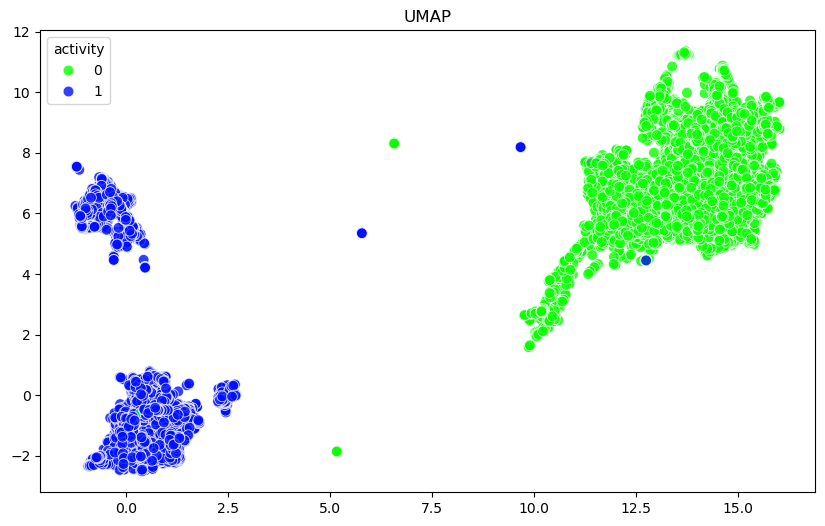

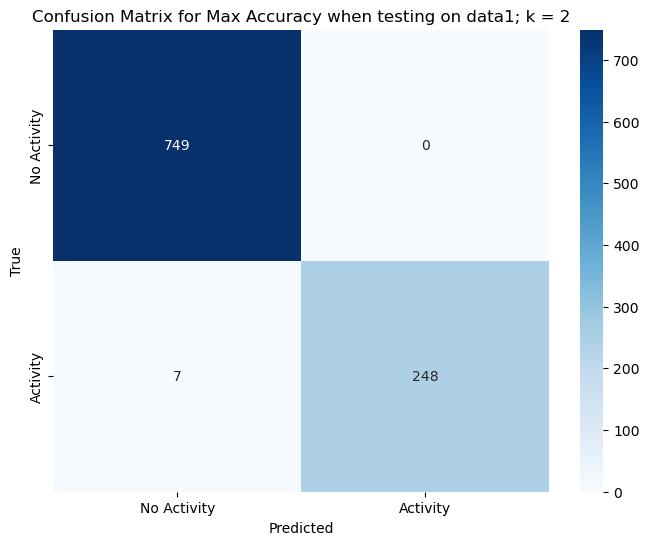

data1 has been tested on everyone


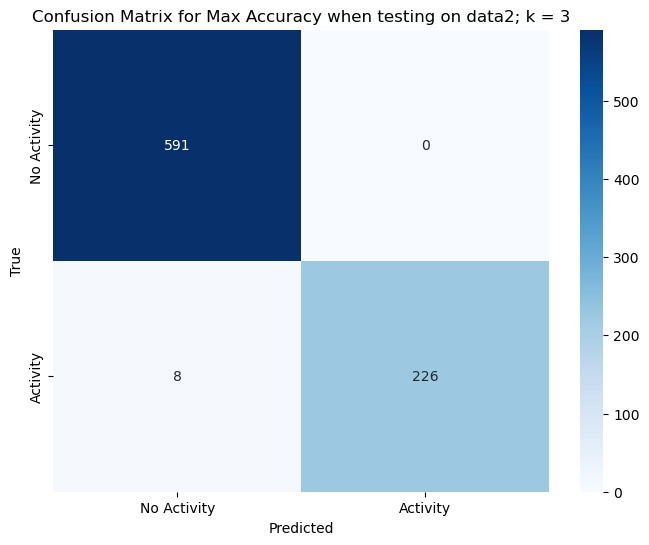

data2 has been tested on everyone


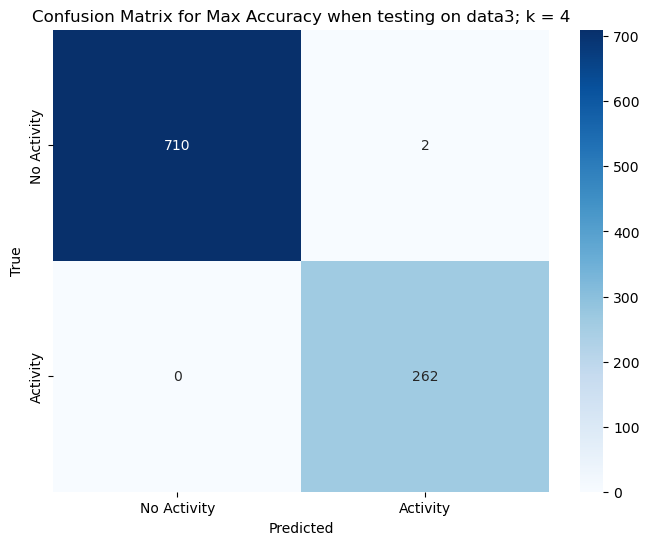

data3 has been tested on everyone


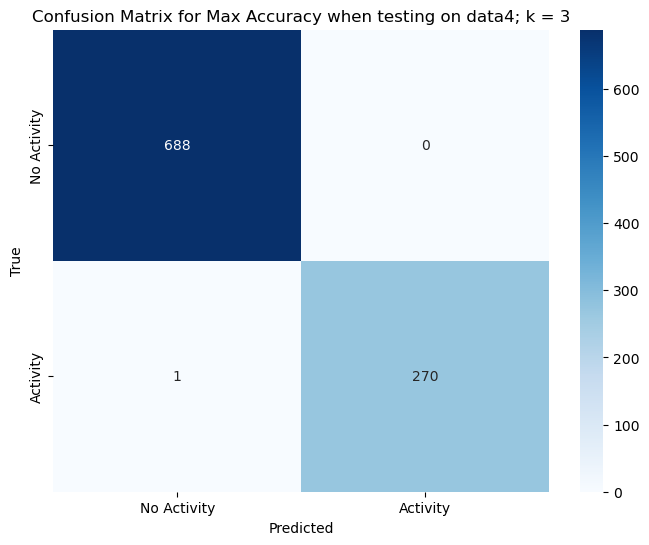

data4 has been tested on everyone


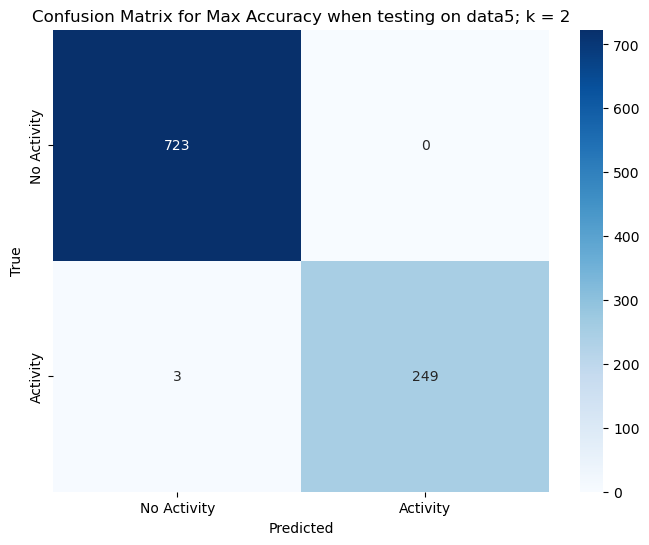

data5 has been tested on everyone


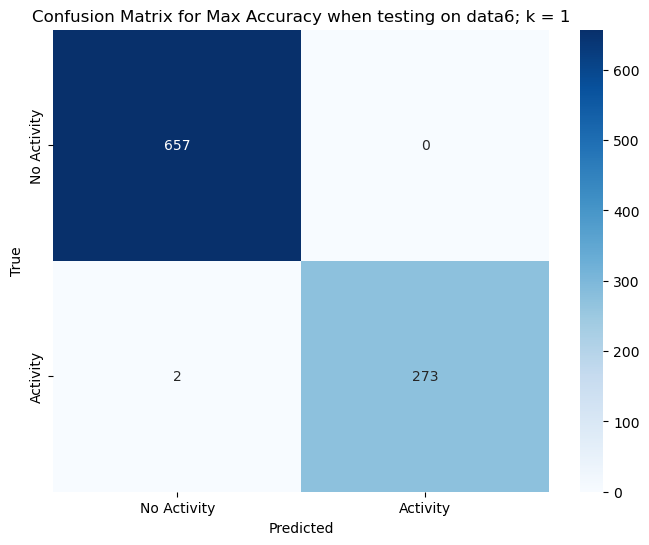

data6 has been tested on everyone


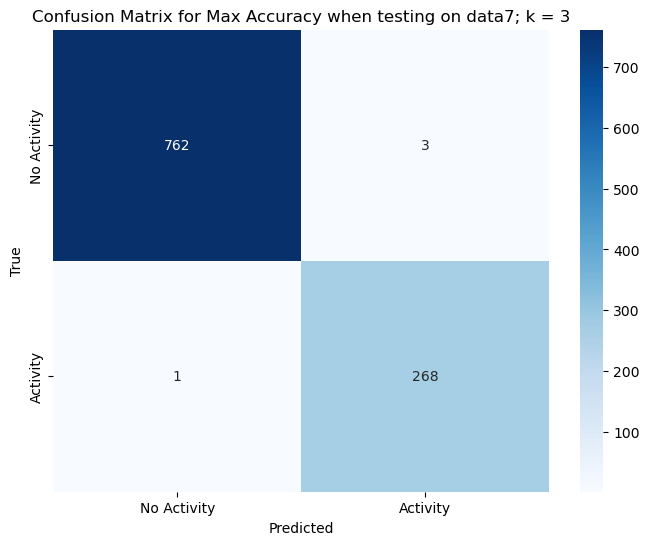

data7 has been tested on everyone


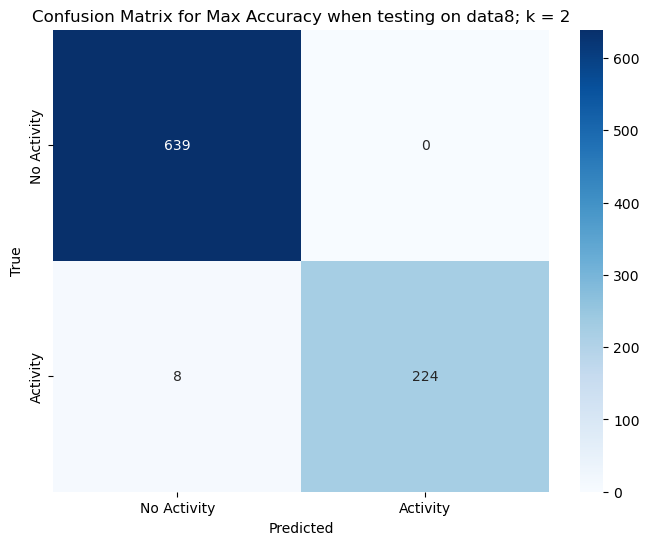

data8 has been tested on everyone


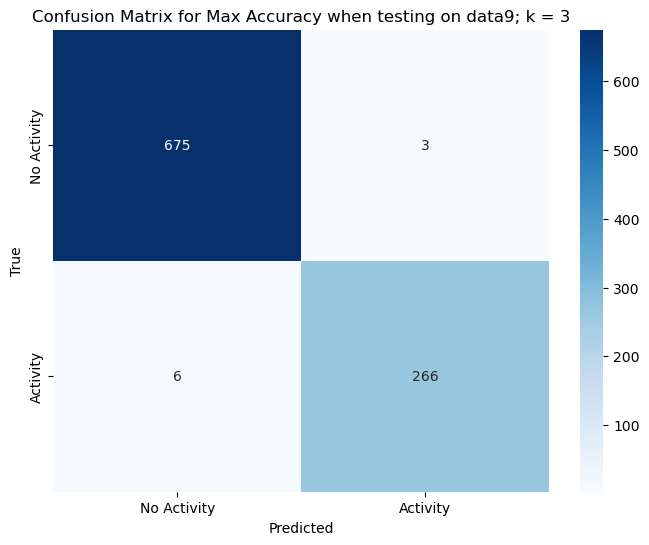

data9 has been tested on everyone


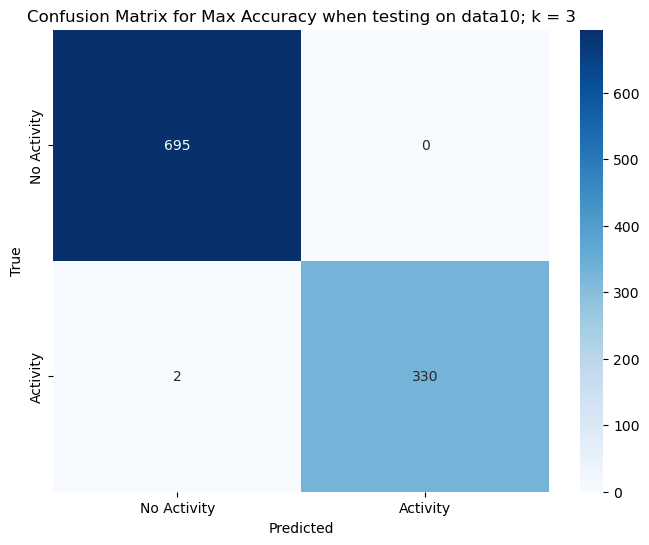

data10 has been tested on everyone


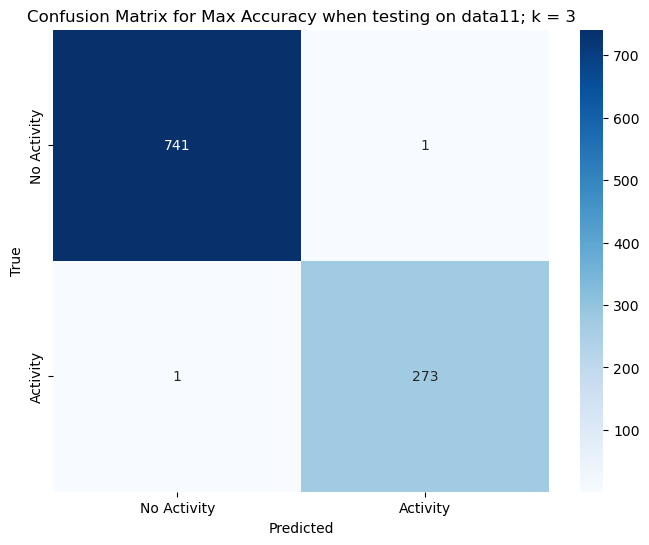

data11 has been tested on everyone


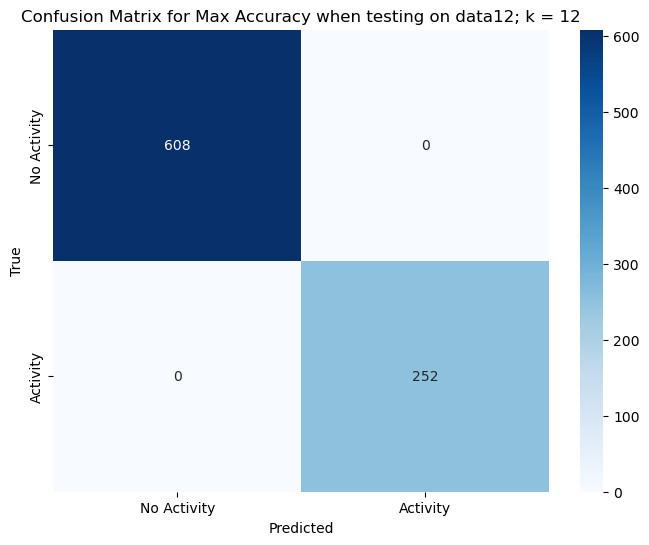

data12 has been tested on everyone


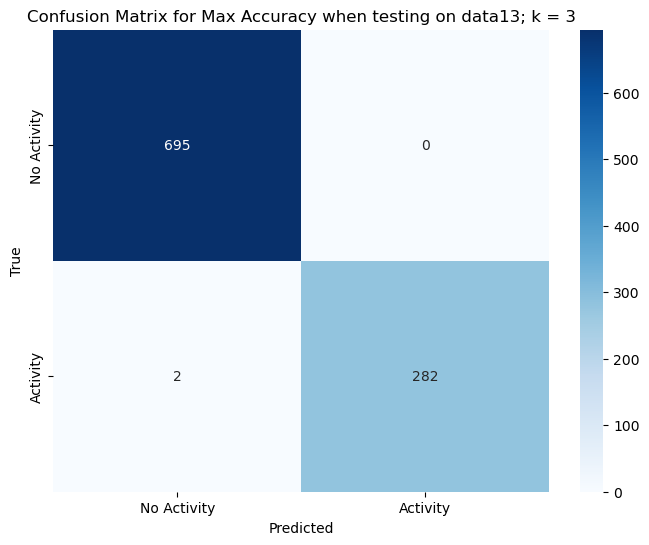

data13 has been tested on everyone


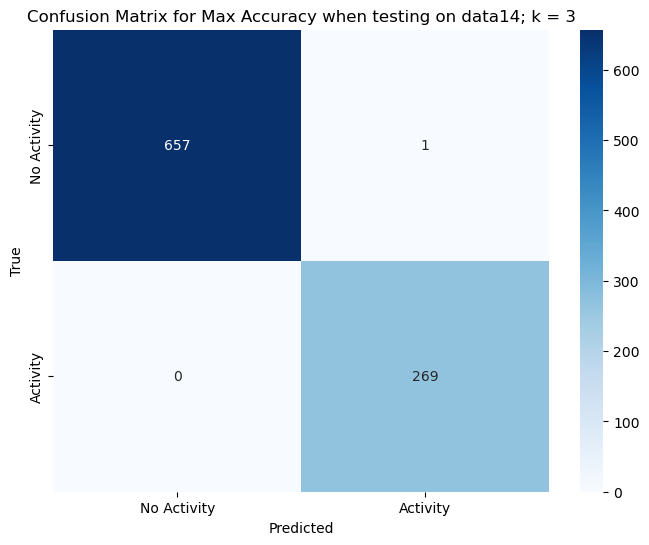

data14 has been tested on everyone


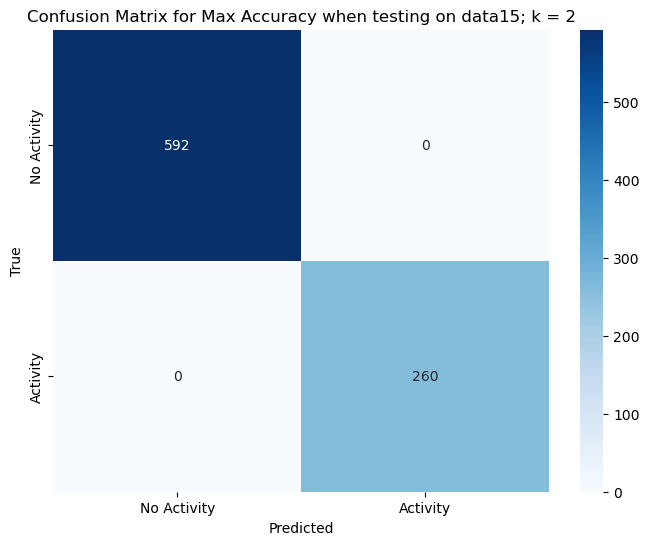

data15 has been tested on everyone


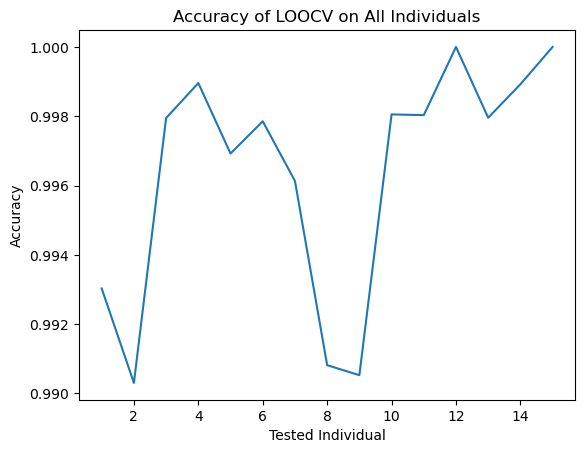

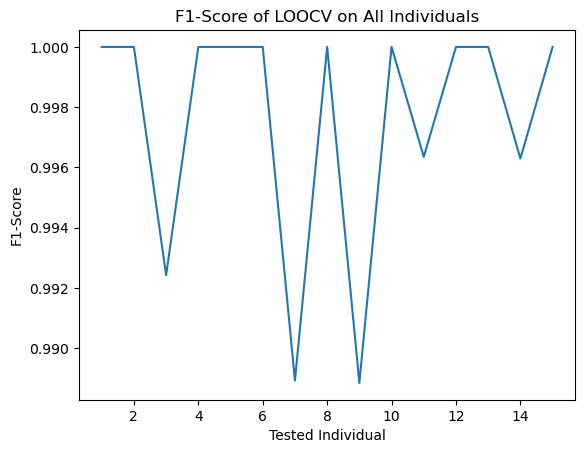

Average Accuracy:  0.9963631571747308
Average F1-Score:  0.997523225108404


In [ ]:
## ACC_specific_windowed_features.csv
## HR_specific_windowed_features.csv
## BVP_specific_windowed_features.csv
## Supervised UMAP of all individuals
## 0: baseline + misc
## 1: activity
def plot_clusters(X, y, title):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("hsv", len(np.unique(y)))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, legend='full', palette=palette, s=60, alpha=0.8)
    plt.title(title)
    plt.show()

dataframes = {}
for i in np.arange(1,16):
    name = f"data{i}"
    acc = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/ACC_specific_windowed_features.csv")
    hr = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/HR_specific_windowed_features.csv")
    bvp = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/BVP_specific_windowed_features.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time', 'activity']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures  = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data = data[~data['activity'].isin([0])]
    data.loc[data['activity'].isin([1, 2, 7,8,9]), 'activity'] = 0
    data.loc[data['activity'].isin([3,4,5,6]), 'activity'] = 1
    dataframes[name] = data

combined_df = pd.concat(dataframes.values(), ignore_index=True)
numerical_cols = [col for col in combined_df.columns if col != 'activity']
scaled_data = StandardScaler().fit_transform(combined_df[numerical_cols])

fitter = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3).fit(scaled_data, y=combined_df["activity"])
X_umap = fitter.embedding_
umap_df = pd.DataFrame(data=X_umap, columns=[f'UMAP{i}' for i in np.arange(1, 4)])
umap_df['activity'] = combined_df['activity']
plot_clusters(X_umap, umap_df['activity'], "UMAP")

start_idx = 0
for key, df in dataframes.items():
    end_idx = start_idx + len(df)
    dataframes[key] = umap_df.iloc[start_idx:end_idx].reset_index(drop=True)
    start_idx = end_idx

LOOCVAccuracy = np.array([])
LOOCVf1_score = np.array([])
for tester in dataframes:
    trainingFeatures  = [col for col in dataframes[tester].columns if col not in ["activity", "start_time", "end_time"]]

    testingFeatures = dataframes[tester][trainingFeatures].to_numpy()
    testingActivity = dataframes[tester]["activity"].to_numpy()

    X_train = pd.DataFrame()
    y_train = pd.DataFrame()
    for trainer in dataframes:
        if trainer != tester:
            X_train = pd.concat([X_train, dataframes[trainer][trainingFeatures]], ignore_index=True)
            y_train = pd.concat([y_train, dataframes[trainer]["activity"]], ignore_index=True)

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().flatten()

    testingFeatures = StandardScaler().fit_transform(testingFeatures)
    X_train = StandardScaler().fit_transform(X_train)

    k = np.arange(1,100)
    accuracy = np.array([])
    f1score = np.array([])
    maxAccK = 0
    maxF1K = 0
    maxAcc = 0
    maxF1 = 0
    for i in k:
        knn = KNeighborsClassifier(i)
        knn.fit(X_train, y_train)
        acc = (accuracy_score(testingActivity, knn.predict(testingFeatures)))
        f1 = precision_score(testingActivity, knn.predict(testingFeatures))
        accuracy = np.append(accuracy, acc)
        f1score = np.append(f1score, f1)
        if acc > maxAcc:
            maxAccK = i
            maxAcc = acc
        if f1 > maxF1:
            maxF1K = i
            maxF1 = f1


    knn = KNeighborsClassifier(maxAccK)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(testingFeatures)
    cmat = confusion_matrix(testingActivity, y_pred) #validate model predictions with actual y values
    labels = ["No Activity", "Activity"]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmat, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix for Max Accuracy when testing on {tester}; k = {maxAccK}")
    plt.show()

    LOOCVAccuracy = np.append(LOOCVAccuracy, accuracy_score(testingActivity, y_pred))
    LOOCVf1_score = np.append(LOOCVf1_score, precision_score(testingActivity, y_pred))

    print(f"{tester} has been tested on everyone")

plt.plot(np.arange(1,16), LOOCVAccuracy)
plt.title("Accuracy of LOOCV on All Individuals")
plt.xlabel("Tested Individual")
plt.ylabel("Accuracy")
plt.show()

plt.plot(np.arange(1,16), LOOCVf1_score)
plt.title("F1-Score of LOOCV on All Individuals")
plt.xlabel("Tested Individual")
plt.ylabel("F1-Score")
plt.show()

print("Average Accuracy: ", sum(LOOCVAccuracy) / len(LOOCVAccuracy))
print("Average F1-Score: ", sum(LOOCVf1_score) / len(LOOCVf1_score))


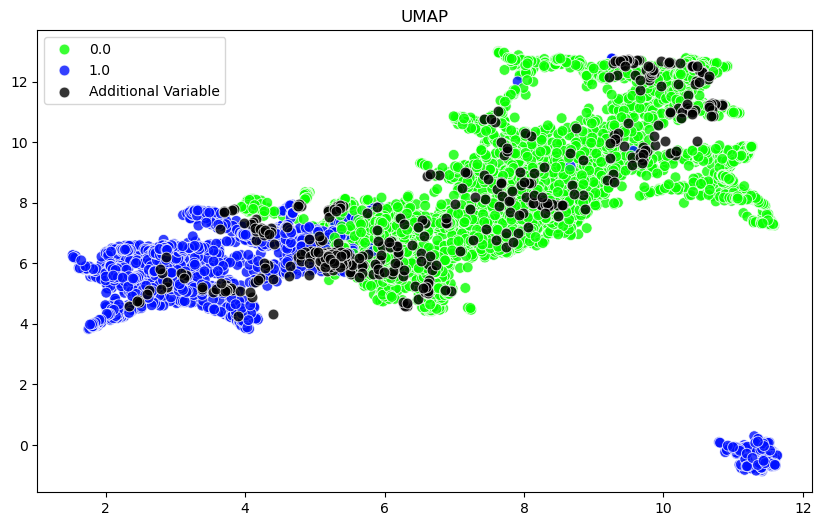

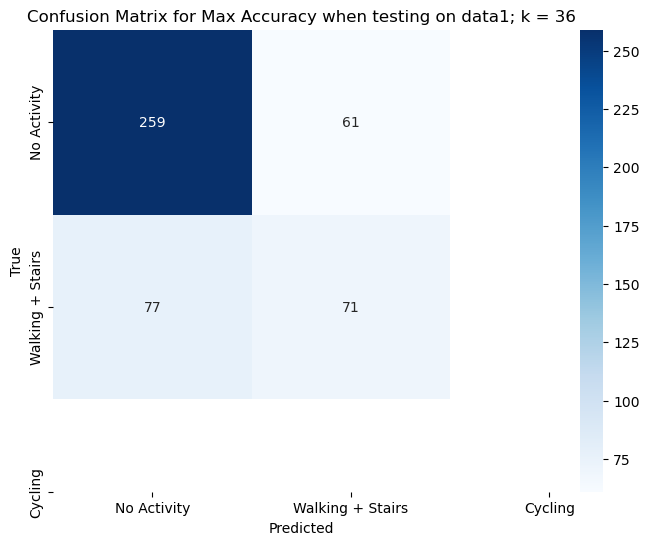

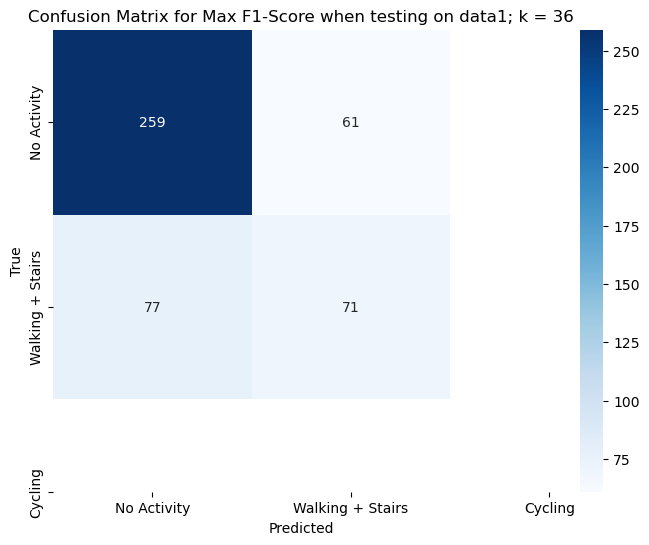

data1 has been tested on everyone


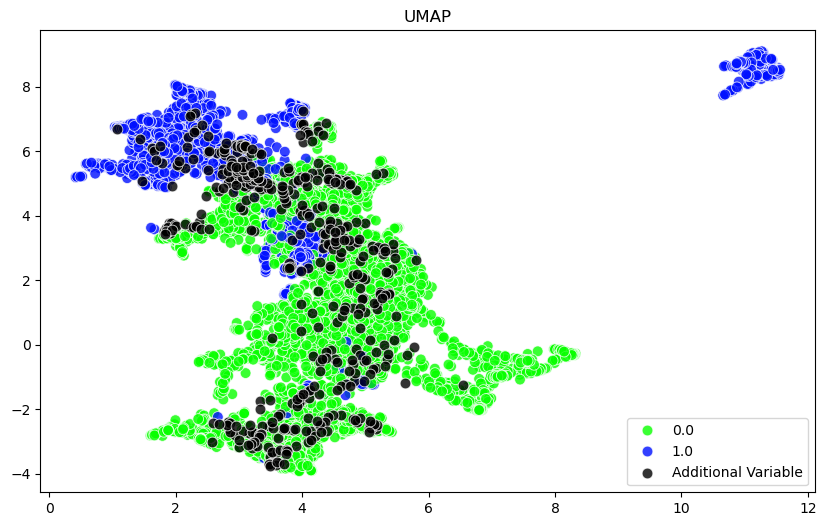

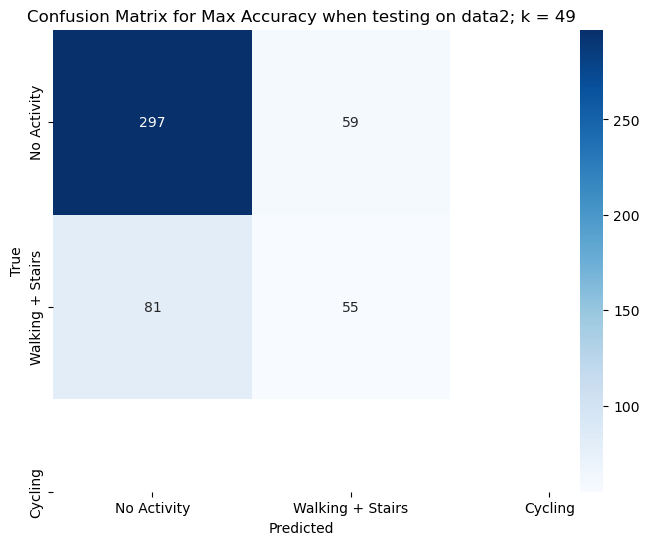

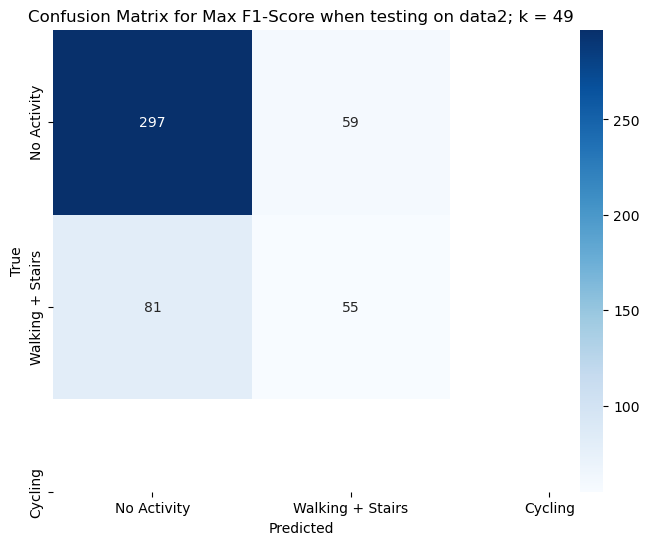

data2 has been tested on everyone


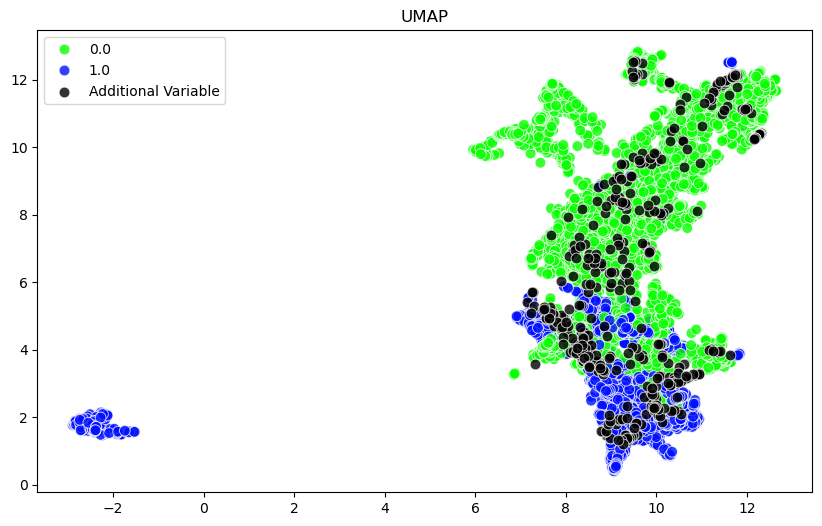

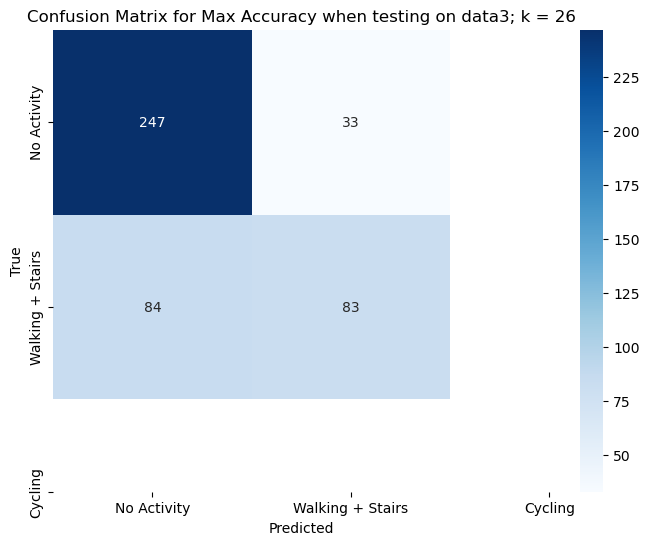

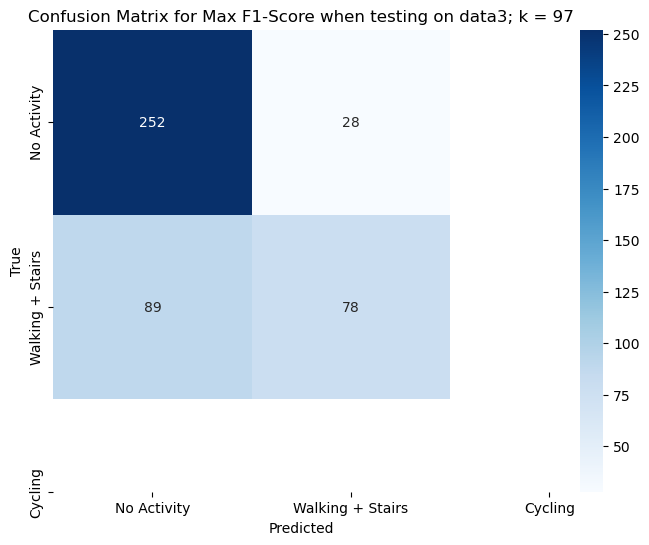

data3 has been tested on everyone


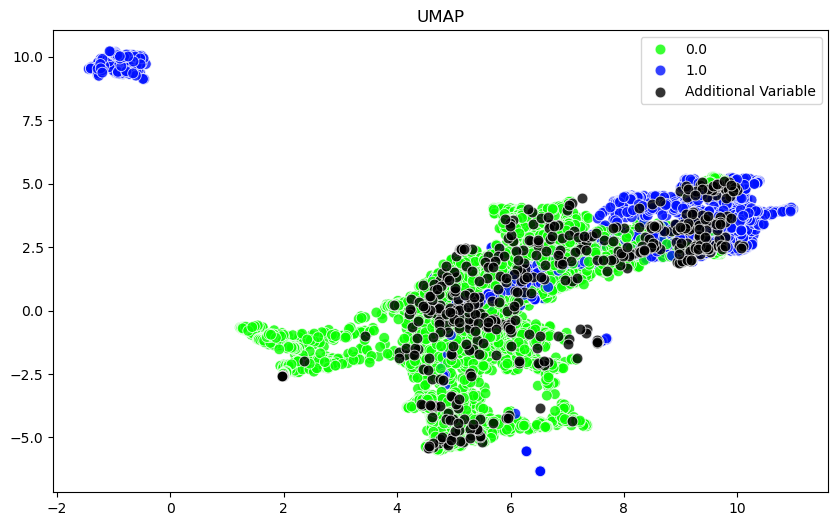

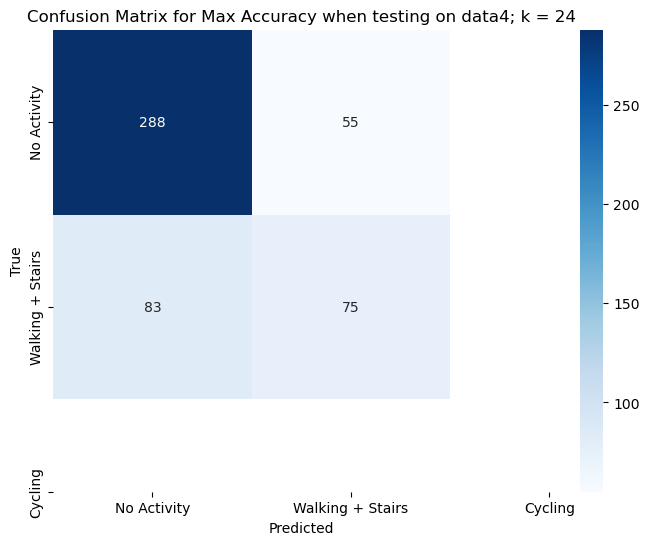

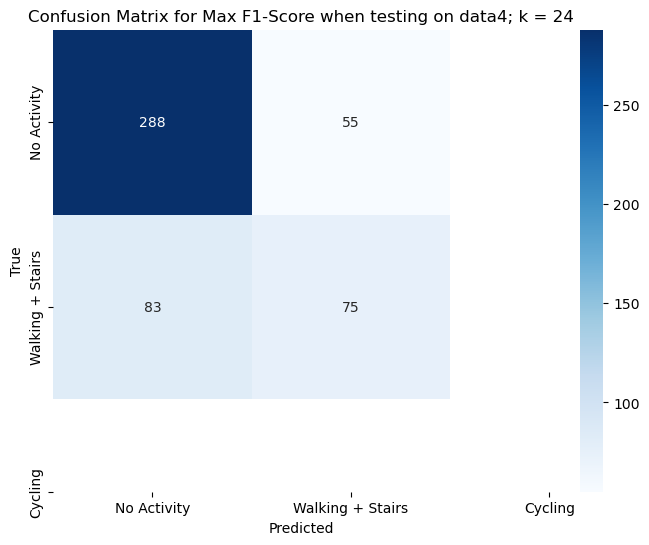

data4 has been tested on everyone


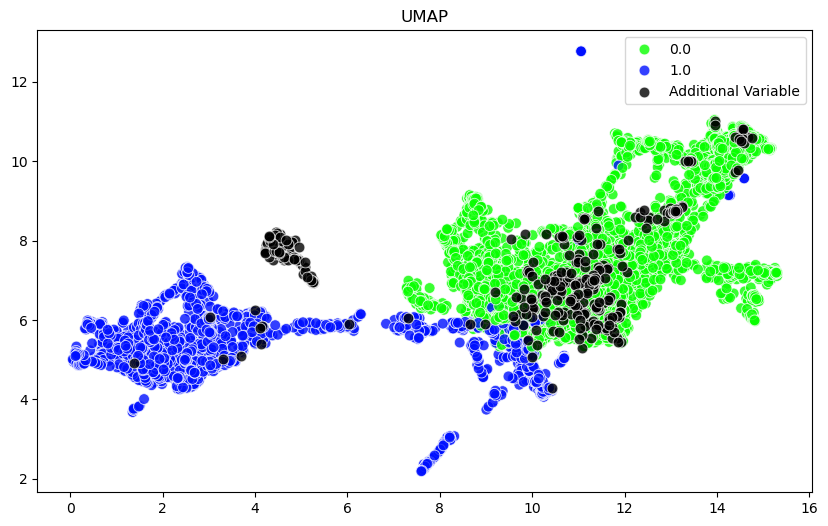

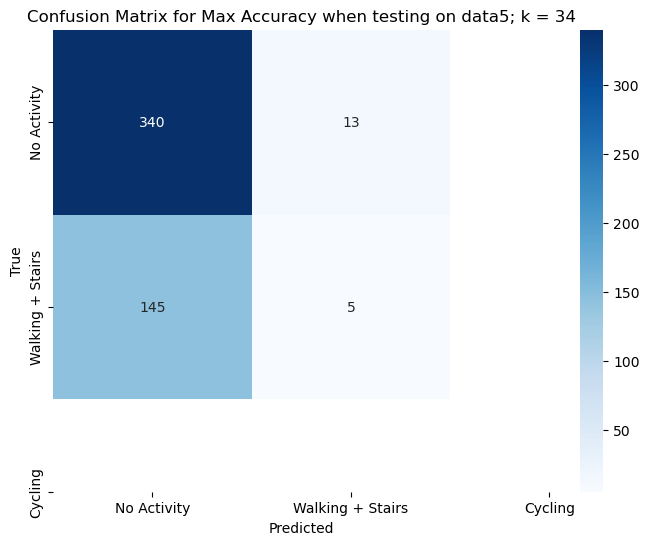

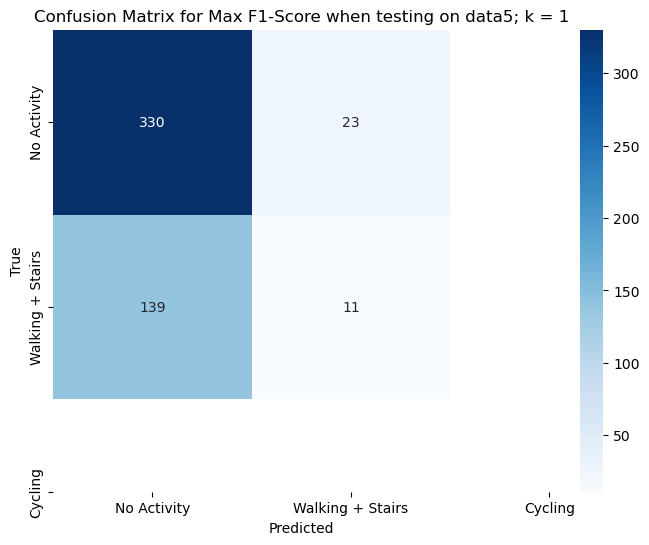

data5 has been tested on everyone


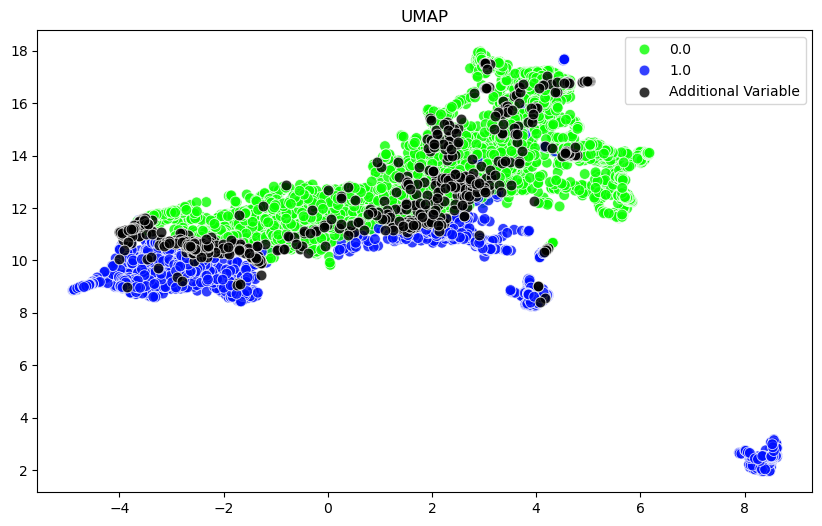

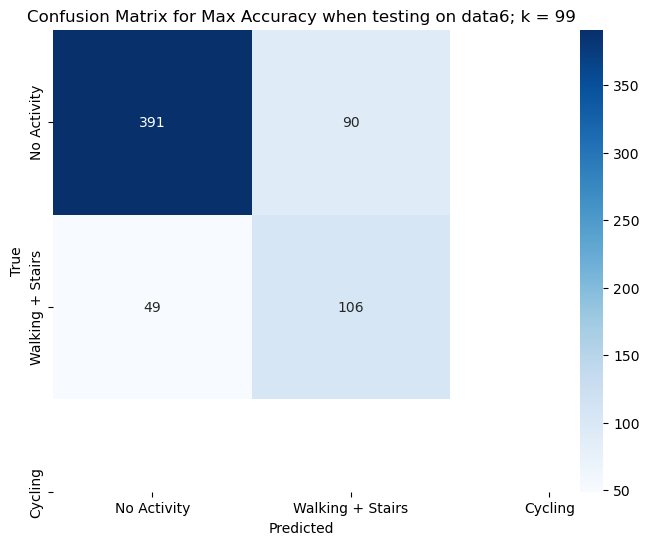

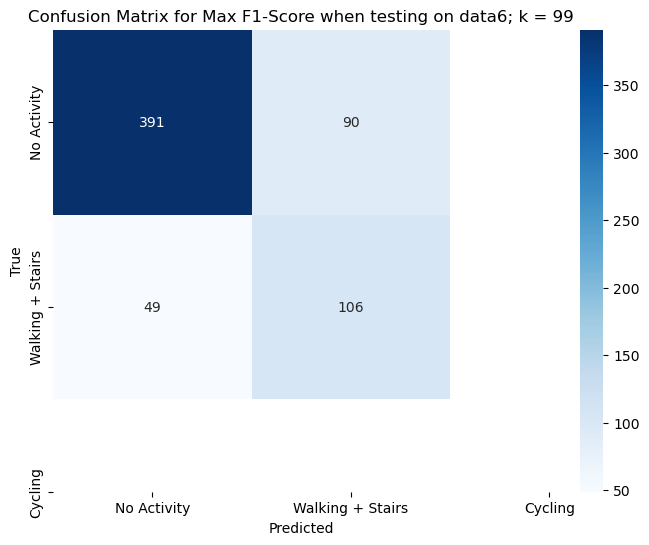

data6 has been tested on everyone


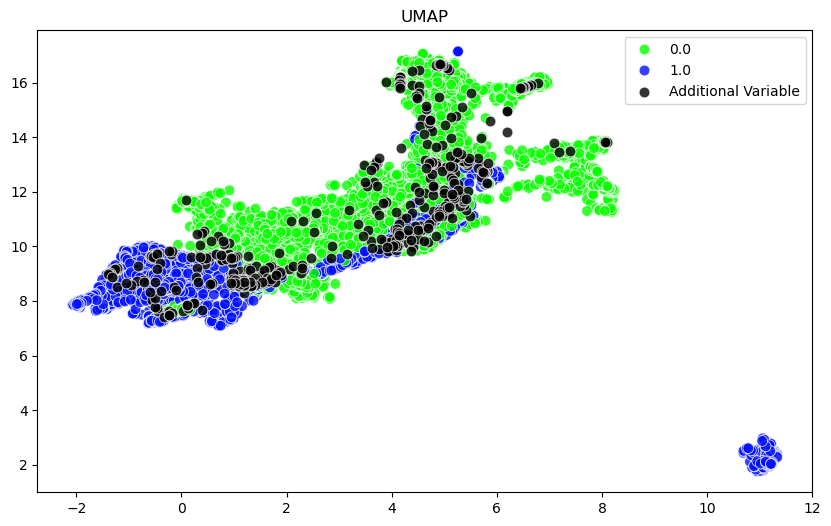

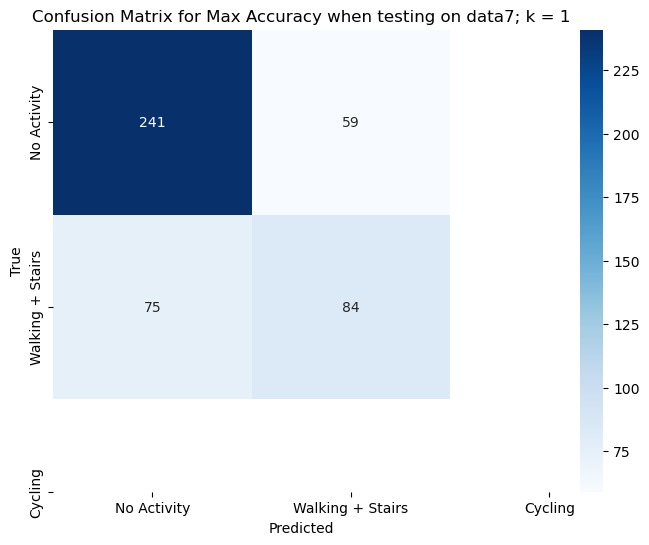

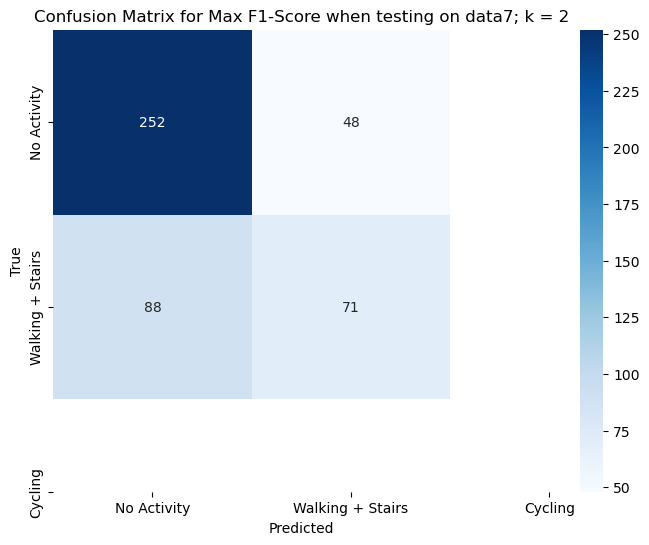

data7 has been tested on everyone


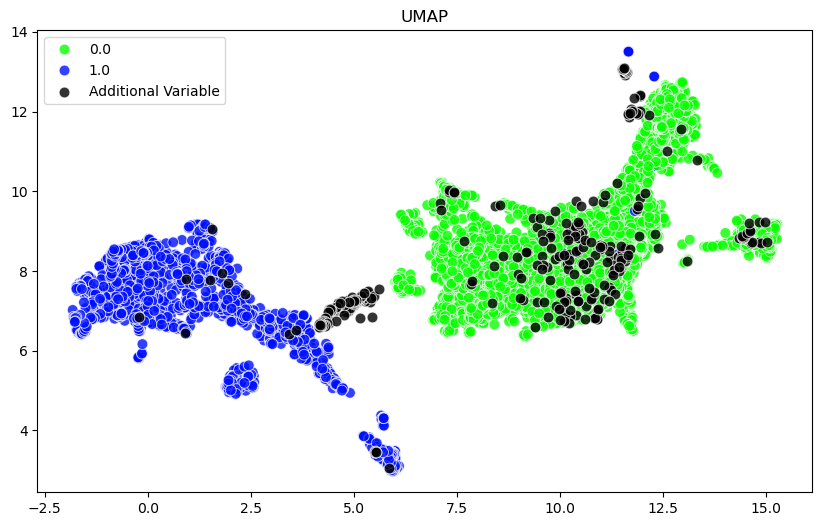

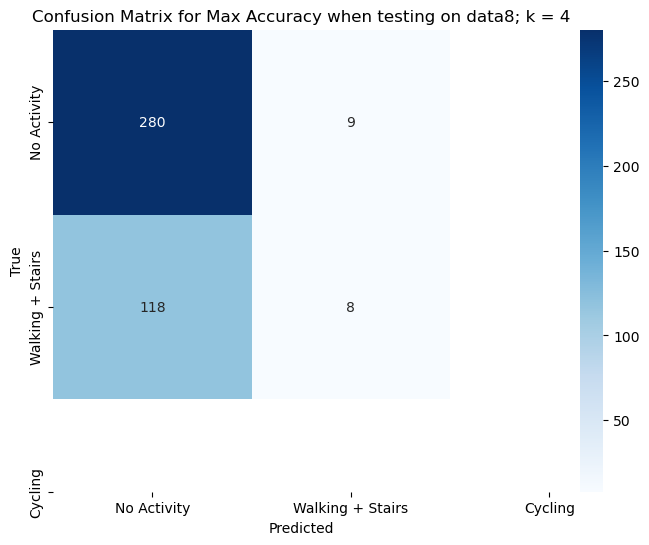

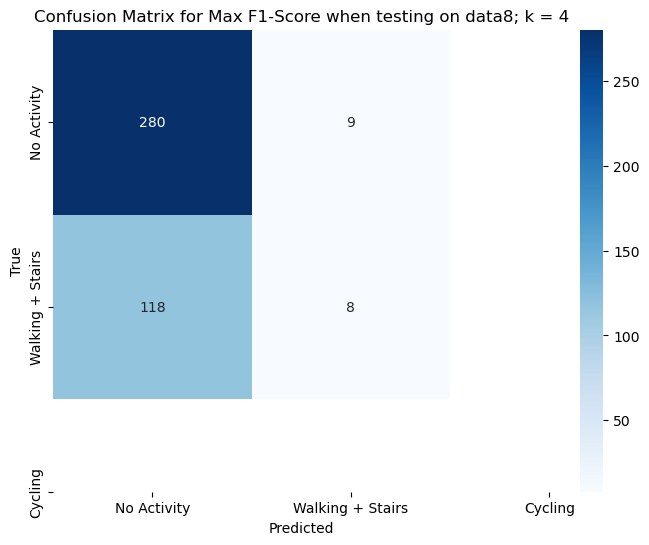

data8 has been tested on everyone


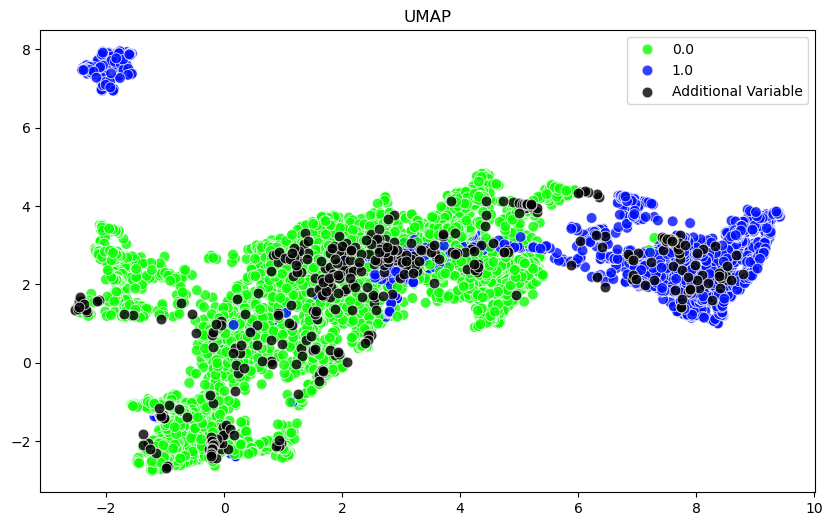

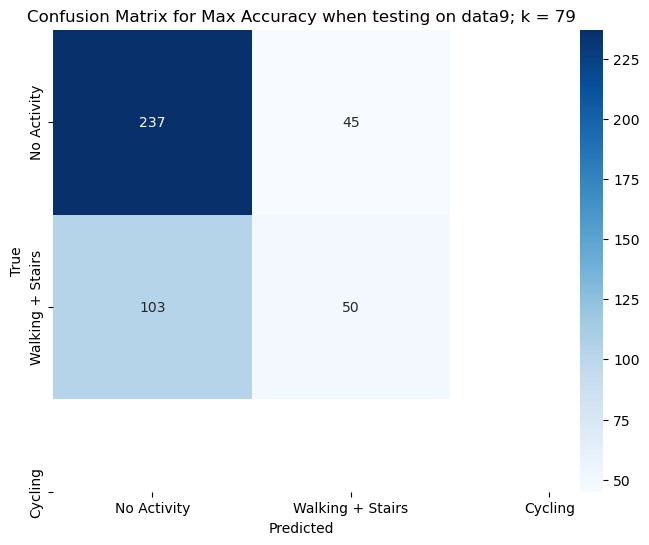

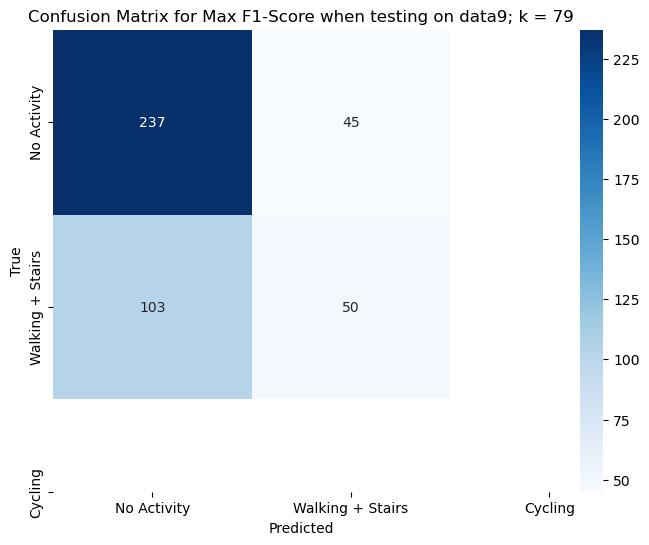

data9 has been tested on everyone


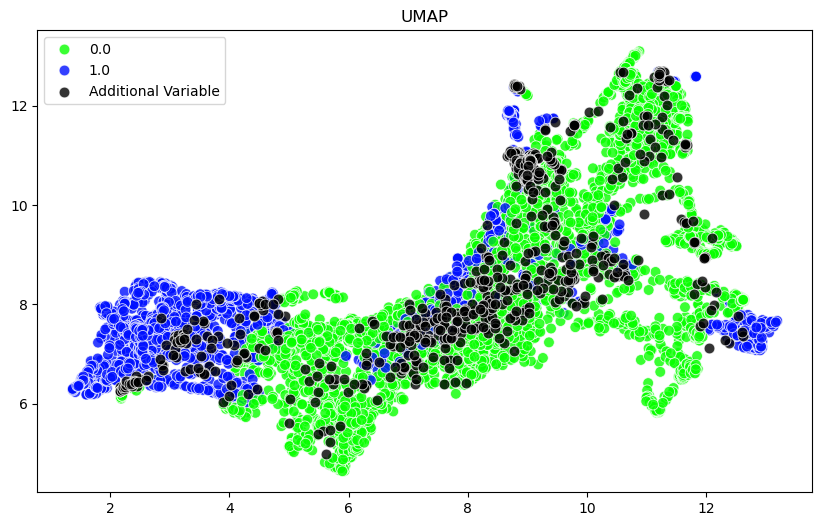

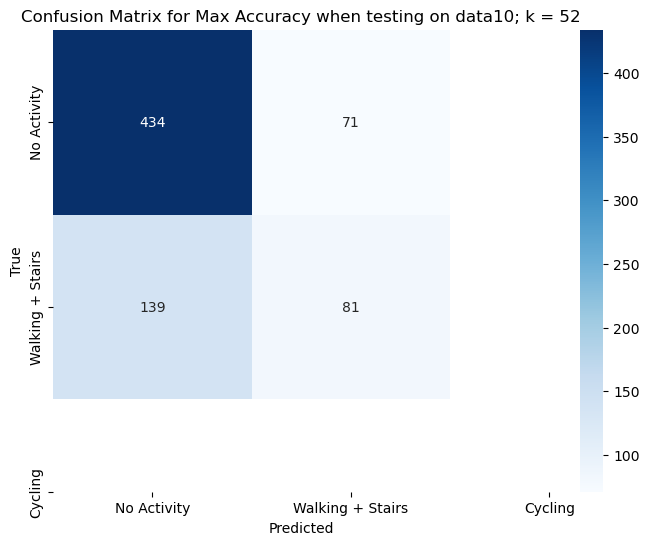

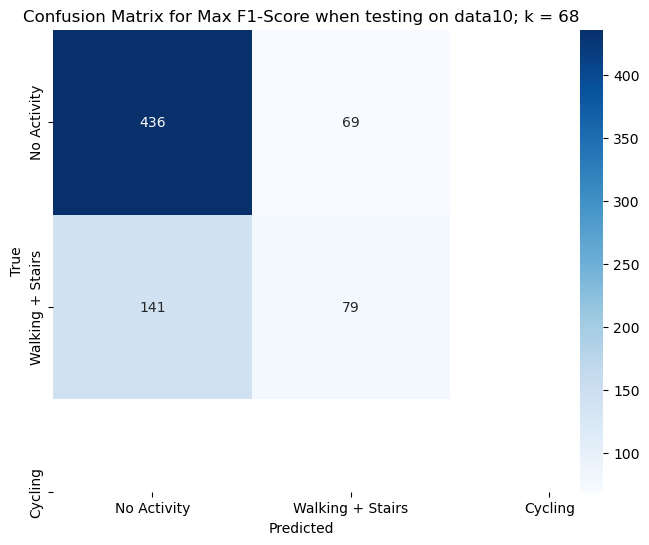

data10 has been tested on everyone


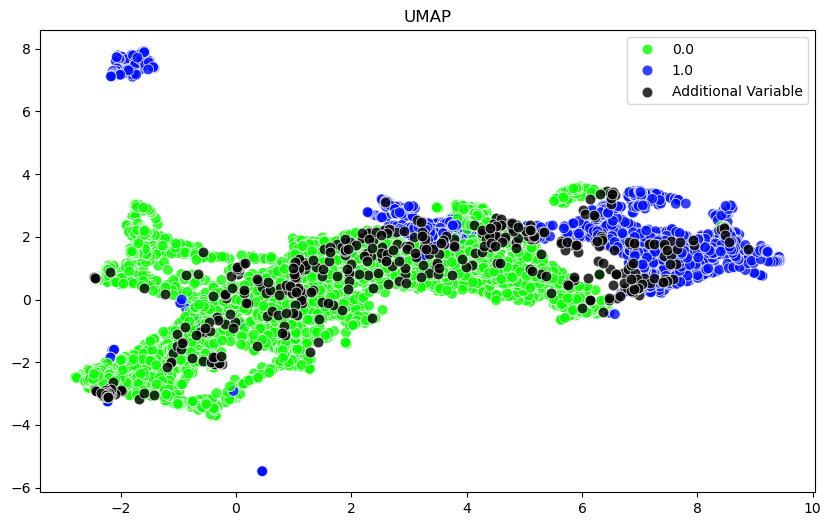

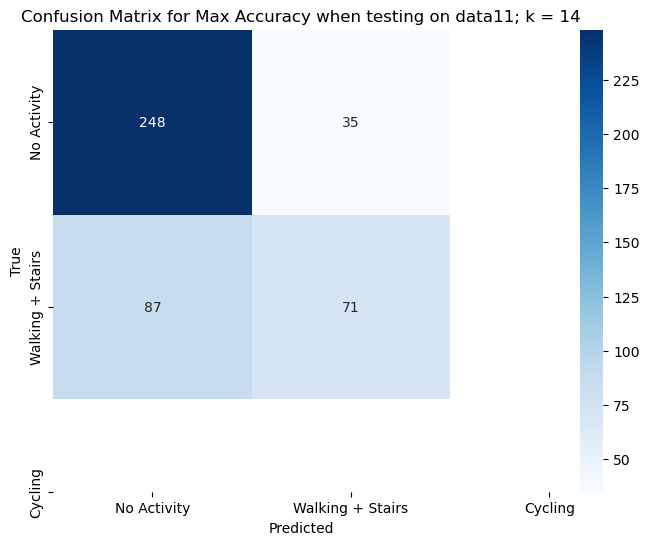

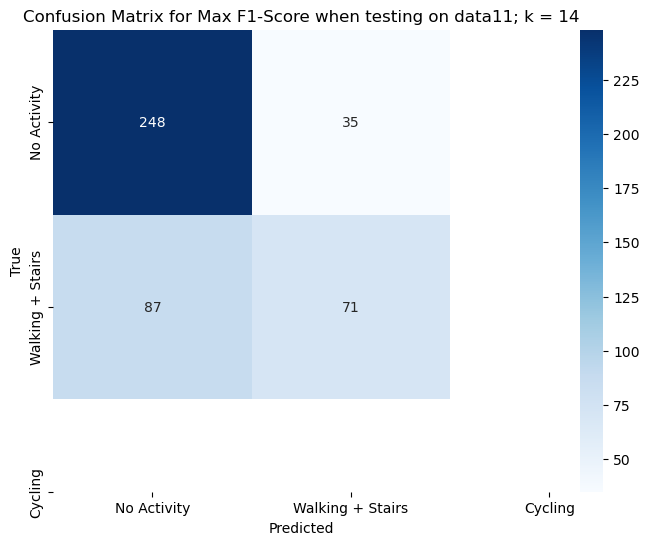

data11 has been tested on everyone


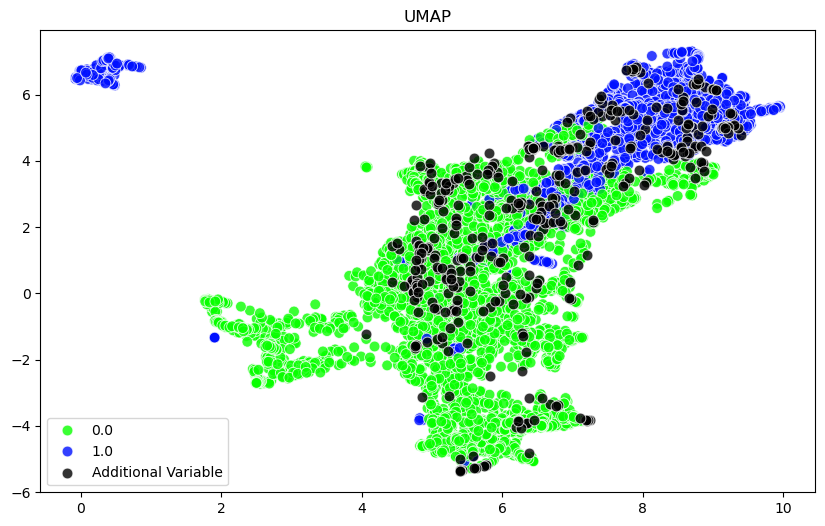

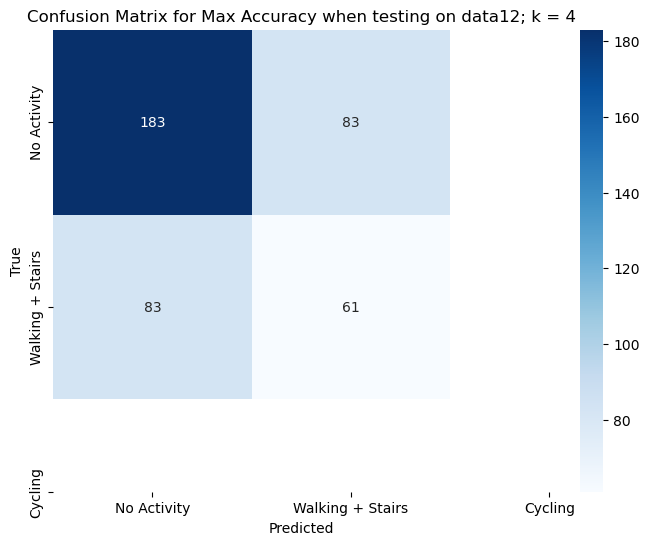

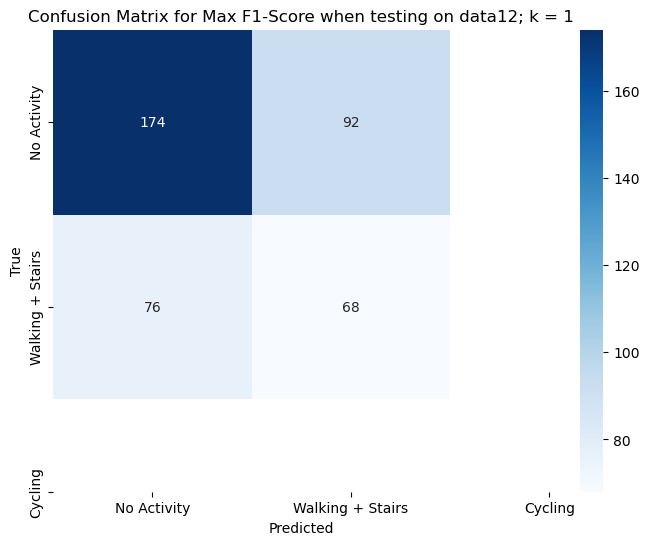

data12 has been tested on everyone


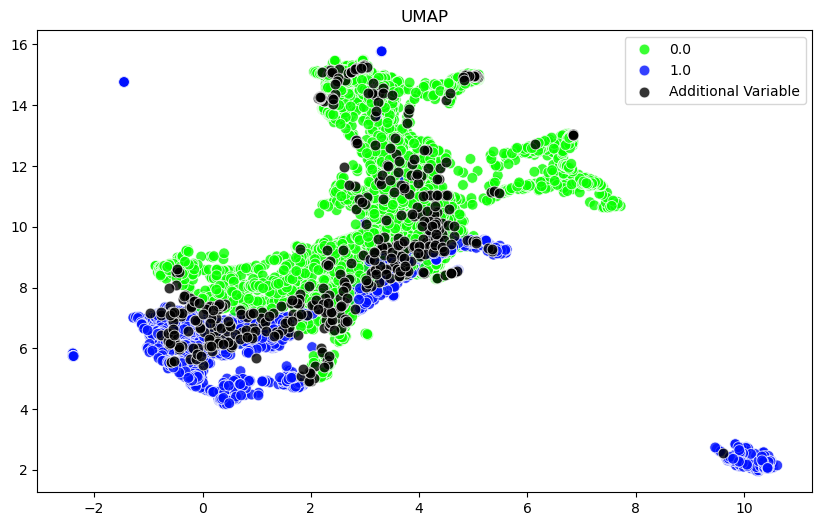

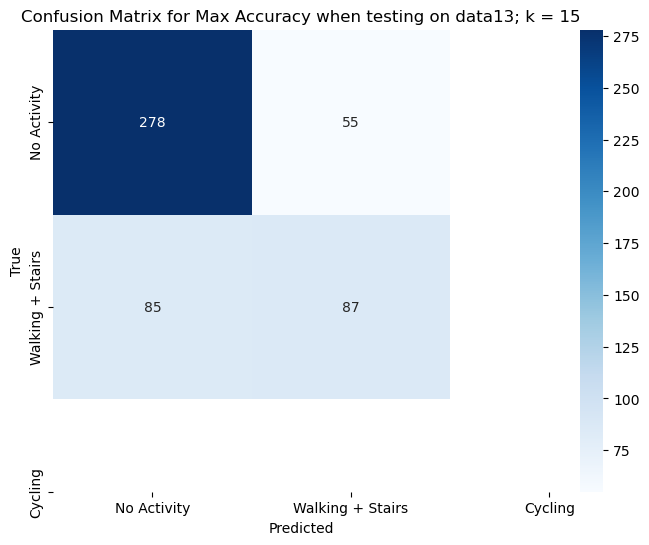

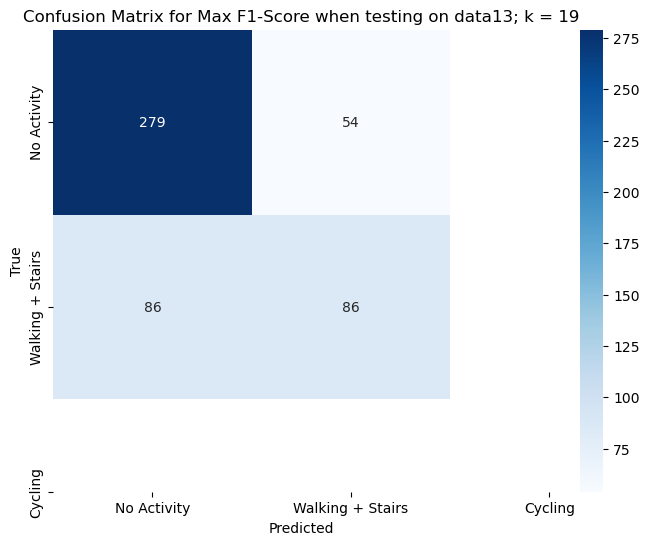

data13 has been tested on everyone


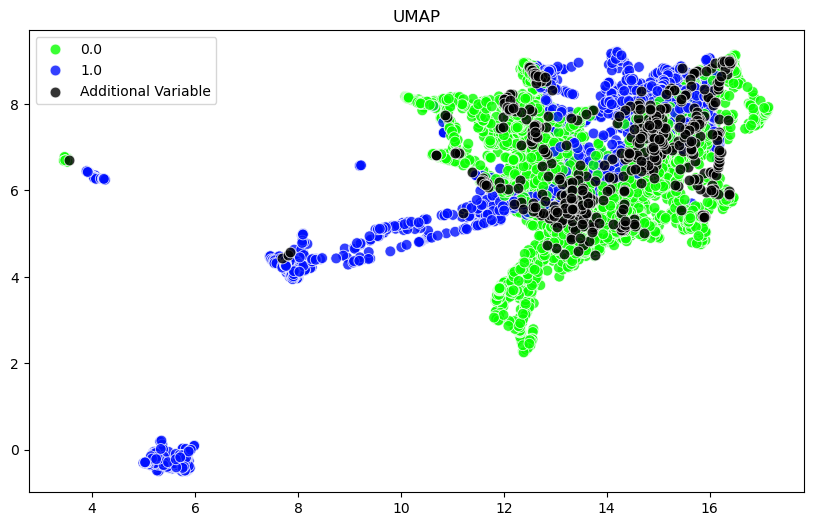

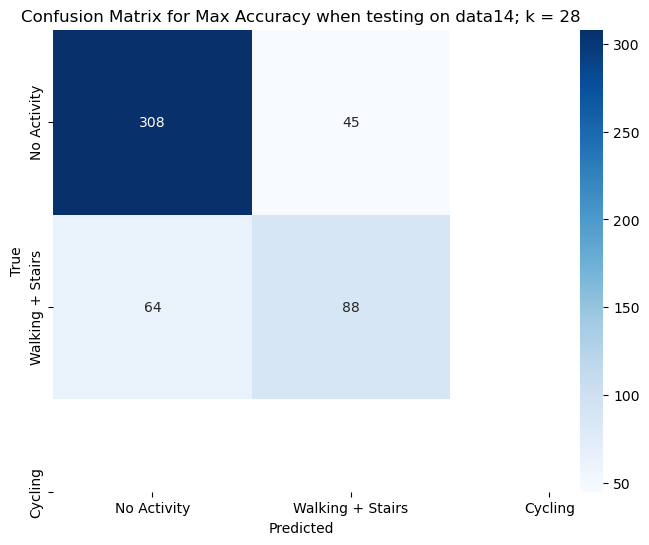

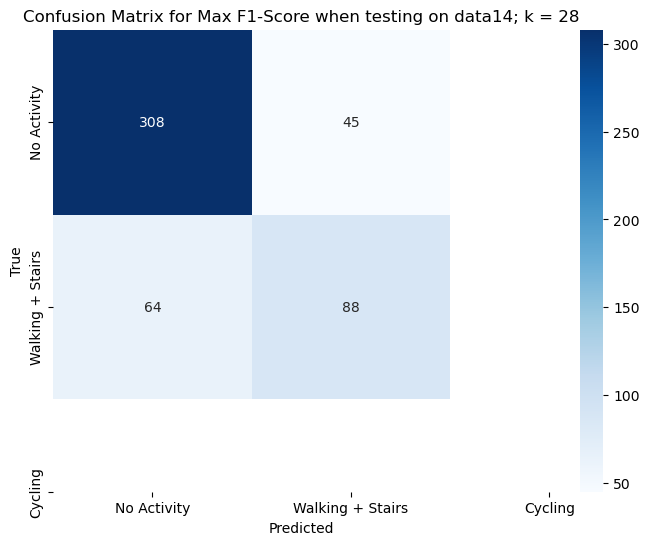

data14 has been tested on everyone


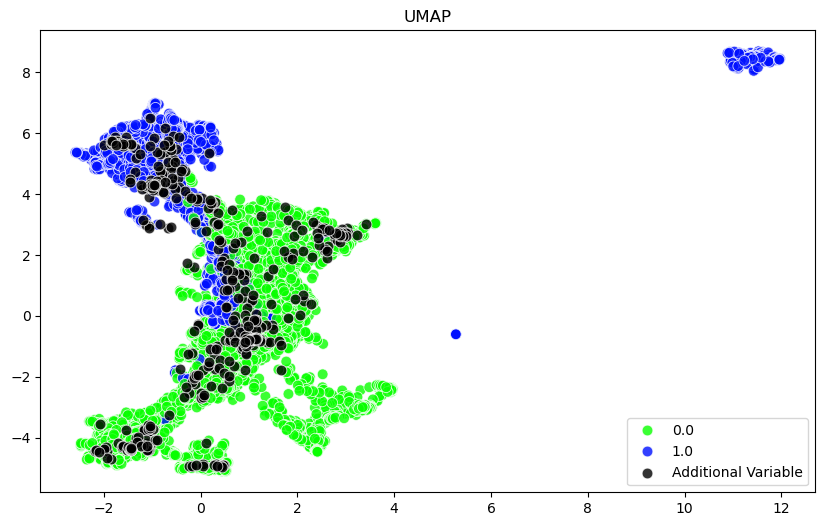

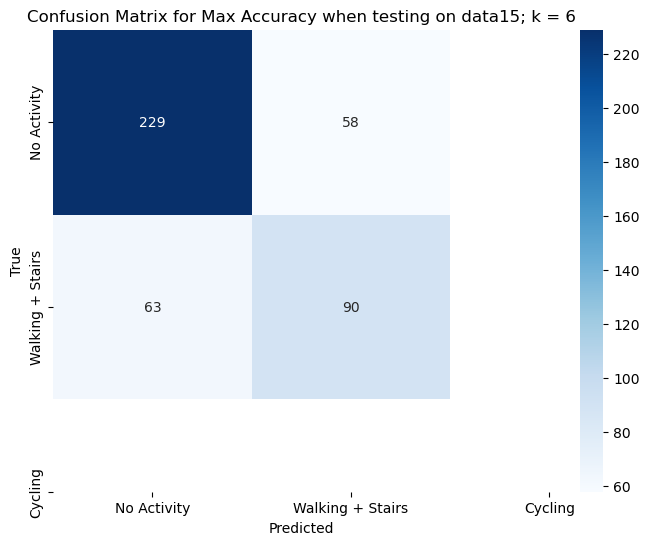

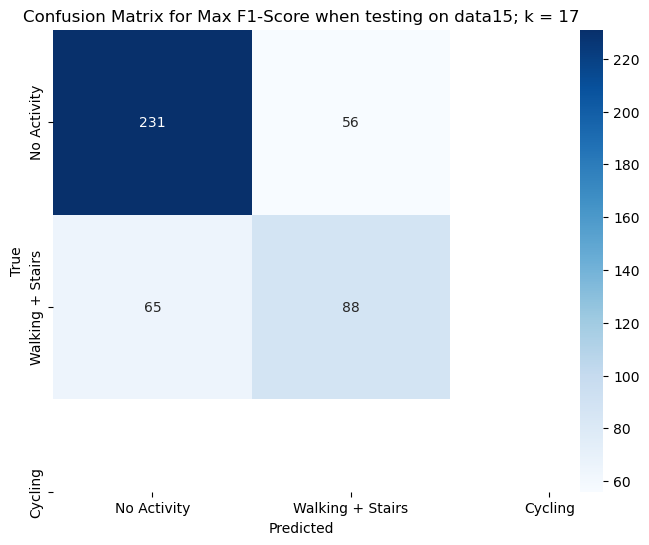

data15 has been tested on everyone


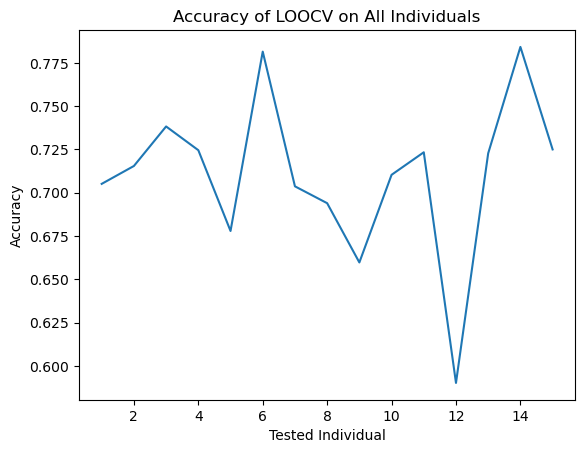

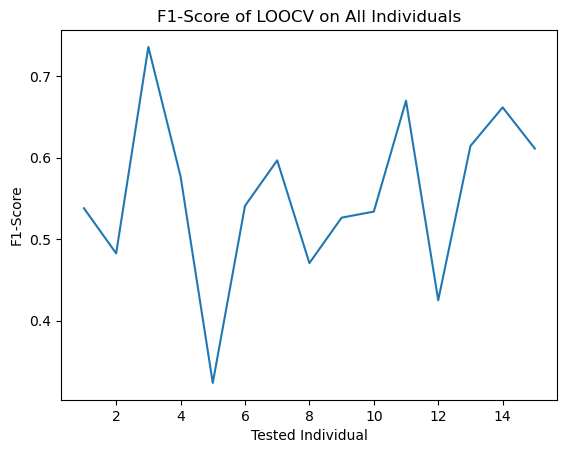

Average Accuracy:  0.7104056928155345
Average F1-Score:  0.5537761030370327


In [ ]:
## ACC_specific_windowed_features.csv
## HR_specific_windowed_features.csv
## BVP_specific_windowed_features.csv
## Supervised UMAP for each Leave One Individual Out Test
## 0: no activity
## 1: stairs + walking
def plot_clusters(X, y, test, title):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("hsv", len(np.unique(y)))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, legend='full', palette=palette, s=60, alpha=0.8)
    sns.scatterplot(x=test[:, 0], y=test[:, 1], color='black', s=60, alpha=0.8, label='Additional Variable')
    plt.title(title)
    plt.show()

dataframes = {}
for i in np.arange(1,16):
    name = f"data{i}"
    acc = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/ACC_specific_windowed_features.csv")
    hr = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/HR_specific_windowed_features.csv")
    bvp = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/BVP_specific_windowed_features.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time', 'activity']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures  = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data = data[~data['activity'].isin([4, 5, 1,2,7,8,9])]
    data.loc[data['activity'].isin([3, 6]), 'activity'] = 1
    dataframes[name] = data

LOOCVAccuracy = np.array([])
LOOCVf1_score = np.array([])
for tester in dataframes:
    trainingFeatures  = [col for col in dataframes[tester].columns if col not in ["activity", "start_time", "end_time"]]

    testingFeatures = dataframes[tester][trainingFeatures].to_numpy()
    testingActivity = dataframes[tester]["activity"].to_numpy()

    X_train = pd.DataFrame()
    y_train = pd.DataFrame()
    for trainer in dataframes:
        if trainer != tester:
            X_train = pd.concat([X_train, dataframes[trainer][trainingFeatures]], ignore_index=True)
            y_train = pd.concat([y_train, dataframes[trainer]["activity"]], ignore_index=True)

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().flatten()

    testingFeatures = StandardScaler().fit_transform(testingFeatures)
    X_train = StandardScaler().fit_transform(X_train)

    X_combined = np.vstack((X_train, testingFeatures))
    y_combined = np.concatenate((y_train, -1 * np.ones(testingActivity.shape[0])))

    # Apply UMAP
    fitter = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3).fit(X_combined, y=y_combined)
    X_combined_umap = fitter.embedding_
    X_combined_umap = fitter.fit_transform(X_combined, y=y_combined)

    # Split back into training and testing
    X_train = X_combined_umap[:X_train.shape[0]]
    testingFeatures = X_combined_umap[X_train.shape[0]:]

    plot_clusters(X_train, y_train, testingFeatures, "UMAP")

    k = np.arange(1,100)
    accuracy = np.array([])
    f1score = np.array([])
    maxAccK = 0
    maxF1K = 0
    maxAcc = 0
    maxF1 = 0
    for i in k:
        knn = KNeighborsClassifier(i)
        knn.fit(X_train, y_train)
        acc = (accuracy_score(testingActivity, knn.predict(testingFeatures)))
        f1 = precision_score(testingActivity, knn.predict(testingFeatures))
        accuracy = np.append(accuracy, acc)
        f1score = np.append(f1score, f1)
        if acc > maxAcc:
            maxAccK = i
            maxAcc = acc
        if f1 > maxF1:
            maxF1K = i
            maxF1 = f1


    knn = KNeighborsClassifier(maxAccK)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(testingFeatures)
    cmat = confusion_matrix(testingActivity, y_pred) #validate model predictions with actual y values
    labels = ["No Activity", "Walking + Stairs", "Cycling"]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmat, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix for Max Accuracy when testing on {tester}; k = {maxAccK}")
    plt.show()

    knn = KNeighborsClassifier(maxF1K)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(testingFeatures)
    cmat = confusion_matrix(testingActivity, y_pred) #validate model predictions with actual y values
    labels = ["No Activity", "Walking + Stairs", "Cycling"]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmat, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix for Max F1-Score when testing on {tester}; k = {maxF1K}")
    plt.show()

    LOOCVAccuracy = np.append(LOOCVAccuracy, accuracy_score(testingActivity, y_pred))
    LOOCVf1_score = np.append(LOOCVf1_score, precision_score(testingActivity, y_pred))

    print(f"{tester} has been tested on everyone")

plt.plot(np.arange(1,16), LOOCVAccuracy)
plt.title("Accuracy of LOOCV on All Individuals")
plt.xlabel("Tested Individual")
plt.ylabel("Accuracy")
plt.show()

plt.plot(np.arange(1,16), LOOCVf1_score)
plt.title("F1-Score of LOOCV on All Individuals")
plt.xlabel("Tested Individual")
plt.ylabel("F1-Score")
plt.show()

print("Average Accuracy: ", sum(LOOCVAccuracy) / len(LOOCVAccuracy))
print("Average F1-Score: ", sum(LOOCVf1_score) / len(LOOCVf1_score))


In [ ]:
## ACC_specific_windowed_features.csv
## HR_specific_windowed_features.csv
## BVP_specific_windowed_features.csv
## umap
## 0: baseline + misc
## 1: walking + stairs
## 2: cycling

dataframes = {}
for i in np.arange(1,16):
    name = f"data{i}"
    acc = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/ACC_specific_windowed_features.csv")
    hr = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/HR_specific_windowed_features.csv")
    bvp = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/BVP_specific_windowed_features.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time', 'activity']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures  = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data = data[~data['activity'].isin([0,4])]
    data.loc[data['activity'].isin([1,2,7,8,9]), 'activity'] = 0
    data.loc[data['activity'].isin([3, 6]), 'activity'] = 1
    data.loc[data['activity'].isin([5]), 'activity'] = 2
    dataframes[name] = data

k = np.arange(1,101)
maxAccK = 0
maxF1K = 0
maxAcc = 0
maxF1 = 0
for i in k:
    for tester in dataframes:
        LOOCVAccuracy = np.array([])
        LOOCVf1_score = np.array([])
        trainingFeatures  = [col for col in dataframes[tester].columns if col not in ["activity", "start_time", "end_time"]]

        testingFeatures = dataframes[tester][trainingFeatures].to_numpy()
        testingActivity = dataframes[tester]["activity"].to_numpy()

        X_train = pd.DataFrame()
        y_train = pd.DataFrame()
        for trainer in dataframes:
            if trainer != tester:
                X_train = pd.concat([X_train, dataframes[trainer][trainingFeatures]], ignore_index=True)
                y_train = pd.concat([y_train, dataframes[trainer]["activity"]], ignore_index=True)

        X_train = X_train.to_numpy()
        y_train = y_train.to_numpy().flatten()

        testingFeatures = StandardScaler().fit_transform(testingFeatures)
        X_train = StandardScaler().fit_transform(X_train)

        umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
        X_train = umap_reducer.fit_transform(X_train, y=y_train)
        testingFeatures = umap_reducer.transform(testingFeatures)

        knn = KNeighborsClassifier(i)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(testingFeatures)

        LOOCVAccuracy = np.append(LOOCVAccuracy, accuracy_score(testingActivity, y_pred))
        LOOCVf1_score = np.append(LOOCVf1_score, f1_score(testingActivity, y_pred, average='macro'))

    avgAcc = sum(LOOCVAccuracy) / len(LOOCVAccuracy)
    avgPre = sum(LOOCVf1_score) / len(LOOCVf1_score)


    if avgAcc > maxAcc:
        maxAccK = i
        maxAcc = avgAcc
    if avgPre > maxF1:
        maxF1K = i
        maxF1 = avgPre
    print(f"k = {i} tested!")
print(maxAccK)
print(maxAcc)
print(maxF1K)
print(maxF1)